In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Gen 0, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 1, Best Fitness: 0.15057996296476608, Best Individual: (x pow cos(x))
Gen 2, Best Fitness: 0.15057996296476608, Best Individual: (x pow cos(x))
Gen 3, Best Fitness: 0.14201952343930582, Best Individual: (x pow cos(cos(((sin(-1.44926018332831) pow -0.7826518805780966) sub (-0.06195915468711011 pow -0.3435842288501574)))))
Gen 4, Best Fitness: 0.13697832509042296, Best Individual: (x pow cos(cos(((sin(-1.44926018332831) pow -0.7826518805780966) sub x))))
Gen 5, Best Fitness: 0.13470886058217751, Best Individual: ((x pow cos(x)) pow cos(cos(-0.06195915468711011)))
Gen 6, Best Fitness: 0.12657160087910416, Best Individual: ((x pow cos(cos(((sin(-1.44926018332831) pow -0.7826518805780966) sub (x pow cos(x)))))) pow cos(sqrt(x)))
Gen 7, Best Fitness: 0.12657160087910416, Best Individual: ((x pow cos(cos(((sin(-1.44926018332831) pow cos(cos(((sin(-1.44926018332831) pow cos(x)) sub cos(-0.06195915468711011))))) sub (x pow cos(x)))

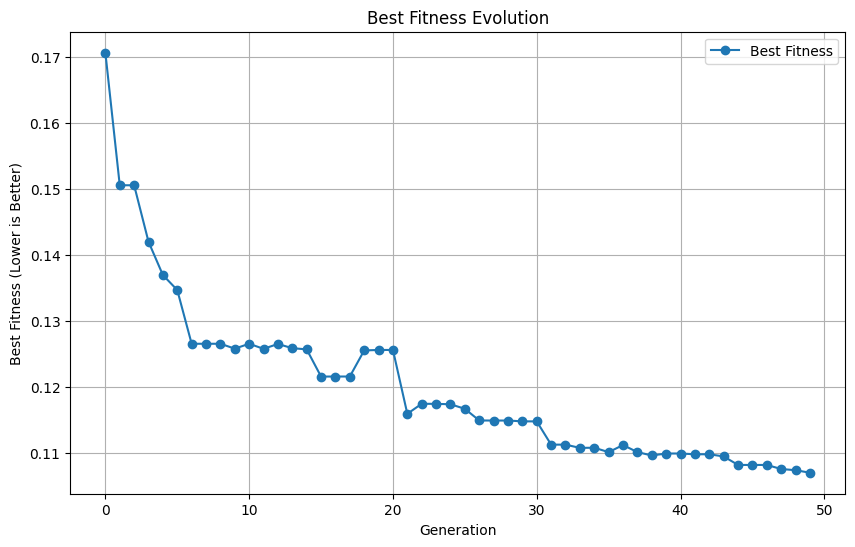

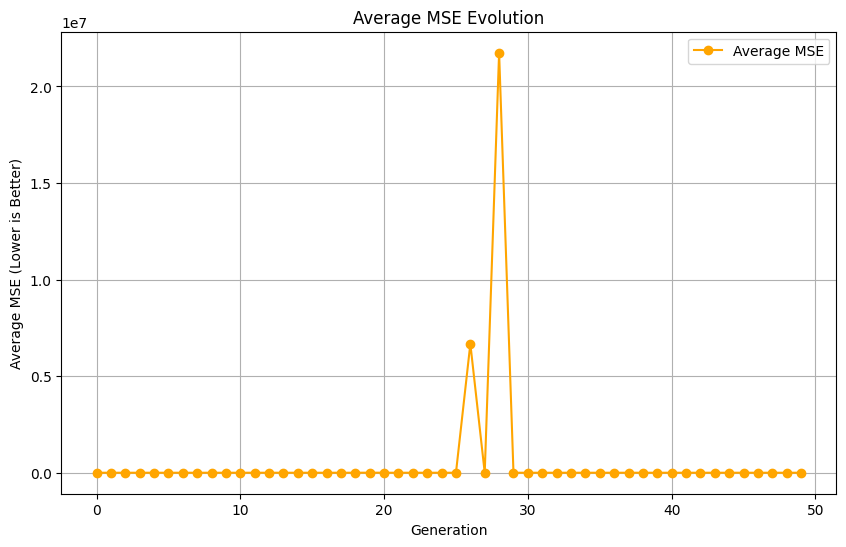

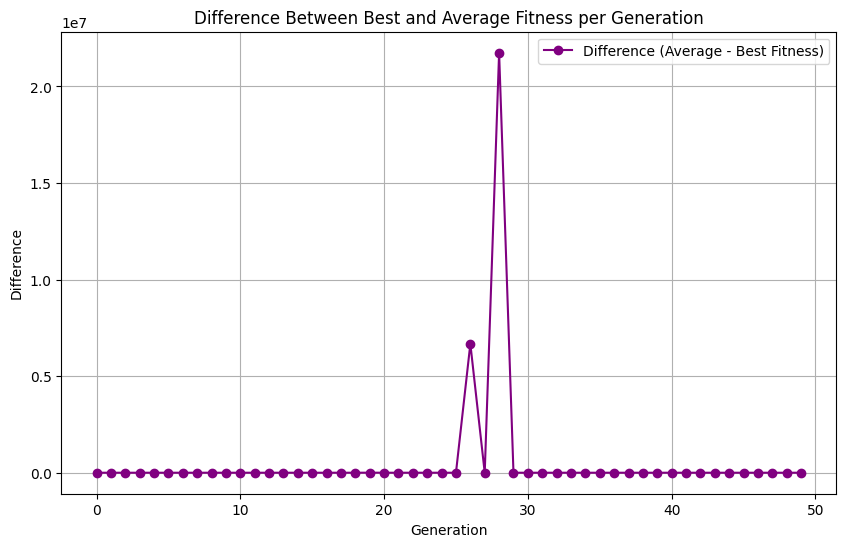

In [10]:
import math
import random
import copy
import matplotlib.pyplot as plt


# ---------- Configuration ----------
POP_SIZE = 50
MAX_DEPTH = 4
GENERATIONS = 50
NUM_CONSTANTS = 5  # how many constants to include

# Training data: x from 0 to 1.0 in steps of 0.1
TRAIN_X = [i/10 for i in range(0, 11)]
def target_function(x):
    # Example target: sin(x) + x^2
    return math.sin(x) + x**2

TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ---------- Function and Terminal Sets ----------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {
        'name': 'pow',
        'arity': 2,
        'func': lambda a, b: (
            a ** b 
            if (a > 0 or (a == 0 and b >= 0) or (a < 0 and float(b).is_integer()))
            else 1.0
        )
    },
    {'name': 'mod', 'arity': 2, 'func': lambda a, b: a % b if b != 0 else 0.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]


# Add a variable and some constants to the terminal set
TERMINALS = ['x']
for _ in range(NUM_CONSTANTS):
    TERMINALS.append(str(random.uniform(-2, 2))) # random constants between -2 and 2

# ---------- Tree Representation ----------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value  # function dict if is_function, else string (var or const)
        self.children = children if children is not None else []
       
    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)


# ---------- Tree Generation ----------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        # Must choose a terminal
        return Node(is_function=False, value=random.choice(terminals))
    else:
        # Decide whether to choose a function or terminal
        if random.random() < 0.5:  # 50% chance for function
            f = random.choice(function_set)
            if f['arity'] == 1:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))


# ---------- Tree Evaluation ----------
def evaluate_tree(node, x_val):
    if node.is_function:
        f = node.value
        if f['arity'] == 1:
            val = evaluate_tree(node.children[0], x_val)
            return f['func'](val)
        else:
            val_left = evaluate_tree(node.children[0], x_val)
            val_right = evaluate_tree(node.children[1], x_val)
            return f['func'](val_left, val_right)
    else:
        # Terminal
        if node.value == 'x':
            return x_val
        else:
            # constant
            return float(node.value)


# ---------- Fitness ----------
def fitness(individual, train_x, train_y):
    error = 0.0
    for x_val, y_val in zip(train_x, train_y):
        pred = evaluate_tree(individual, x_val)
        error += (y_val - pred)**2
    return error / len(train_x)


# ---------- Population Initialization ----------
def initialize_population(pop_size, max_depth, function_set, terminals):
    return [generate_random_tree(max_depth, function_set, terminals) for _ in range(pop_size)]


# ---------- Genetic Operators: Selection, Crossover, Mutation ----------

def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1])
    return selected[0][0]  # Return best individual in the sample


def copy_tree(node):
    if node.is_function:
        new_children = [copy_tree(c) for c in node.children]
        return Node(is_function=True, value=node.value, children=new_children)
    else:
        return Node(is_function=False, value=node.value)

# Helper functions for crossover and mutation
def get_all_nodes(node):
    """ Return a list of all nodes in the tree. """
    nodes = [node]
    for c in node.children:
        nodes.extend(get_all_nodes(c))
    return nodes

def get_random_subtree(node):
    """ Return a random subtree (node) in the tree. """
    all_nodes = get_all_nodes(node)
    return random.choice(all_nodes)

def replace_subtree(original, target, replacement):
    """
    Replace the subtree 'target' in 'original' with 'replacement'.
    'target' must be a subtree of 'original'.
    Return True if replaced, otherwise False.
    """
    if original is target:
        # This is tricky: we need to handle the calling context carefully.
        # We'll just return False here and handle it outside by checking reference identity.
        return False
    for i, c in enumerate(original.children):
        if c is target:
            original.children[i] = replacement
            return True
        else:
            if replace_subtree(c, target, replacement):
                return True
    return False


def crossover(parent1, parent2):
    p1 = copy_tree(parent1)
    p2 = copy_tree(parent2)
    
    # Select a random subtree in parent1
    subtree1 = get_random_subtree(p1)
    # Select a random subtree in parent2
    subtree2 = get_random_subtree(p2)
    
    # We need to replace subtree1 in p1 with subtree2 (copied)
    # Special case: if subtree1 is the root, we just return subtree2 as new root
    if p1 is subtree1:
        return subtree2  # The entire parent1 replaced by subtree2
    else:
        # Replace subtree1 with a copy of subtree2
        subtree2_copy = copy_tree(subtree2)
        replace_subtree(p1, subtree1, subtree2_copy)
        return p1


def mutation(individual, function_set, terminals, max_depth):
    mutant = copy_tree(individual)
    
    # Select a subtree in mutant to replace
    subtree_to_replace = get_random_subtree(mutant)
    
    # Generate a random subtree
    new_subtree = generate_random_tree(max_depth, function_set, terminals)
    
    # If subtree_to_replace is root
    if mutant is subtree_to_replace:
        return new_subtree
    
    # Otherwise, replace the subtree
    replace_subtree(mutant, subtree_to_replace, new_subtree)
    return mutant

def pretty_print(node):
    """Convert a tree node into a human-readable mathematical expression string."""
    if node.is_function:
        fname = node.value['name']
        if fname == 'add':
            return f"({pretty_print(node.children[0])} + {pretty_print(node.children[1])})"
        elif fname == 'sub':
            return f"({pretty_print(node.children[0])} - {pretty_print(node.children[1])})"
        elif fname == 'mul':
            return f"({pretty_print(node.children[0])} * {pretty_print(node.children[1])})"
        elif fname == 'div':
            return f"({pretty_print(node.children[0])} / {pretty_print(node.children[1])})"
        elif fname == 'pow':
            return f"({pretty_print(node.children[0])}^{pretty_print(node.children[1])})"
        elif fname == 'mod':
            return f"({pretty_print(node.children[0])} % {pretty_print(node.children[1])})"
        elif fname == 'sin':
            return f"sin({pretty_print(node.children[0])})"
        elif fname == 'cos':
            return f"cos({pretty_print(node.children[0])})"
        elif fname == 'sqrt':
            return f"sqrt({pretty_print(node.children[0])})"
        else:
            # fallback
            return f"{fname}({', '.join(pretty_print(c) for c in node.children)})"
    else:
        return str(node.value)  # variable 'x' or constant


def print_tree(node, prefix="", is_last=True):
    """
    Print the tree structure using box-drawing characters.
    Example:
    add
    ├── pow
    │   ├── x
    │   └── 2.0
    └── sin
        └── x
    """
    # Choose branch symbols
    branch = "└── " if is_last else "├── "
    connector = "    " if is_last else "│   "
    
    # Print current node
    line = prefix + branch
    if node.is_function:
        line += node.value['name']
    else:
        line += str(node.value)
    print(line)
    
    # Prepare prefix for children
    prefix += connector
    for i, c in enumerate(node.children):
        # For each child, determine if it's the last to adjust formatting
        is_child_last = (i == len(node.children) - 1)
        print_tree(c, prefix=prefix, is_last=is_child_last)



# ---------- Main Evolutionary Loop ----------
population = initialize_population(POP_SIZE, MAX_DEPTH, FUNCTION_SET, TERMINALS)

# Track progress
best_fitness_over_generations = []
average_mse_over_generations = []
difference_best_vs_average = []

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]

        # Track the best and average fitness
    best_fitness = min(fitnesses)
    average_mse = sum(fitnesses) / len(fitnesses)
    best_fitness_over_generations.append(best_fitness)
    average_mse_over_generations.append(average_mse)
    difference = average_mse - best_fitness
    difference_best_vs_average.append(difference)
    
    best_idx = min(range(len(population)), key=lambda i: fitnesses[i])
    print(f"Gen {gen}, Best Fitness: {fitnesses[best_idx]}, Best Individual: {population[best_idx]}")

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses, k=3)
        p2 = tournament_selection(population, fitnesses, k=3)
        child = crossover(p1, p2)
        if random.random() < 0.1:  # Mutation probability
            child = mutation(child, FUNCTION_SET, TERMINALS, MAX_DEPTH)
        new_population.append(child)
    
    population = new_population


# After the evolution ends
final_best_idx = fitnesses.index(min(fitnesses))
final_best_individual = population[final_best_idx]
print("Final Best Individual:", pretty_print(final_best_individual))
print("Final Best Fitness:", fitnesses[final_best_idx])

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(range(GENERATIONS), best_fitness_over_generations, label="Best Fitness", marker="o")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Lower is Better)")
plt.title("Best Fitness Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(GENERATIONS), average_mse_over_generations, label="Average MSE", marker="o", color="orange")
plt.xlabel("Generation")
plt.ylabel("Average MSE (Lower is Better)")
plt.title("Average MSE Evolution")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(GENERATIONS), difference_best_vs_average, label="Difference (Average - Best Fitness)", marker="o", color="purple")
plt.xlabel("Generation")
plt.ylabel("Difference")
plt.title("Difference Between Best and Average Fitness per Generation")
plt.legend()
plt.grid(True)
plt.show()

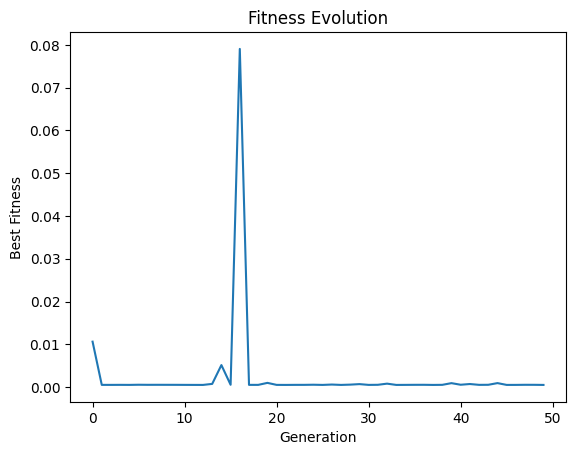

In [8]:
plt.plot(range(len(fitnesses)), fitnesses)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Fitness Evolution")
plt.show()

Gen 0, Best Fitness: 0.17029980115795185, Best Individual: (x pow 0.9964425672005639)
Gen 1, Best Fitness: 0.14261713796298744, Best Individual: sqrt(x)
Gen 2, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 3, Best Fitness: 0.1519531539333305, Best Individual: ((0.9964425672005639 mul 0.032400570691436315) add x)
Gen 4, Best Fitness: 0.14698111210849188, Best Individual: (sqrt(x) pow ((cos(x) div (x add 0.9964425672005639)) add 0.9964425672005639))
Gen 5, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 6, Best Fitness: 0.14261713796298744, Best Individual: sqrt(x)
Gen 7, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 8, Best Fitness: 0.05015234610671738, Best Individual: (x add (x mul (0.9964425672005639 mul (-1.8264996008826935 mod x))))
Gen 9, Best Fitness: 0.1649249713133916, Best Individual: (sqrt(sqrt(x)) div 0.948598607524576)
Gen 10, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 11, Best Fitness: 0.16257147146182324, Best Individual: (x po

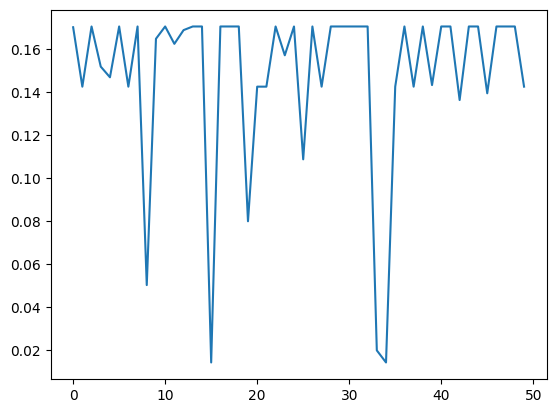

In [11]:
import math
import random
import copy
import matplotlib.pyplot as plt

# ---------- Configuration ----------
POP_SIZE = 50
MAX_DEPTH = 4
GENERATIONS = 50
NUM_CONSTANTS = 5  # how many constants to include

# Training data: x from 0 to 1.0 in steps of 0.1
TRAIN_X = [i / 10 for i in range(0, 11)]
def target_function(x):
    # Example target: sin(x) + x^2
    return math.sin(x) + x**2

TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ---------- Function and Terminal Sets ----------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {
        'name': 'pow',
        'arity': 2,
        'func': lambda a, b: (
            a ** b
            if (a > 0 or (a == 0 and b >= 0) or (a < 0 and float(b).is_integer()))
            else 1.0
        )
    },
    {'name': 'mod', 'arity': 2, 'func': lambda a, b: a % b if b != 0 else 0.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]

# Add a variable and some constants to the terminal set
TERMINALS = ['x']
for _ in range(NUM_CONSTANTS):
    TERMINALS.append(str(random.uniform(-2, 2)))  # random constants between -2 and 2

# ---------- Tree Representation ----------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value  # function dict if is_function, else string (var or const)
        self.children = children if children is not None else []

    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ---------- Tree Generation ----------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        # Must choose a terminal
        return Node(is_function=False, value=random.choice(terminals))
    else:
        # Decide whether to choose a function or terminal
        if random.random() < 0.5:  # 50% chance for function
            f = random.choice(function_set)
            if f['arity'] == 1:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ---------- Tree Evaluation ----------
def evaluate_tree(node, x_val):
    if node.is_function:
        f = node.value
        if f['arity'] == 1:
            val = evaluate_tree(node.children[0], x_val)
            return f['func'](val)
        else:
            val_left = evaluate_tree(node.children[0], x_val)
            val_right = evaluate_tree(node.children[1], x_val)
            return f['func'](val_left, val_right)
    else:
        # Terminal
        if node.value == 'x':
            return x_val
        else:
            # constant
            return float(node.value)

# ---------- Fitness ----------
def fitness(individual, train_x, train_y):
    error = 0.0
    for x_val, y_val in zip(train_x, train_y):
        pred = evaluate_tree(individual, x_val)
        error += (y_val - pred) ** 2
    return error / len(train_x)

# ---------- Simplify Tree ----------
def simplify_tree(node):
    if not node.is_function:
        return node

    simplified_children = [simplify_tree(child) for child in node.children]

    if node.value['name'] == 'add':
        if any(c.value == 0 for c in simplified_children if not c.is_function):
            return [c for c in simplified_children if c.value != 0][0]
        if all(not c.is_function for c in simplified_children):
            return Node(is_function=False, value=simplified_children[0].value + simplified_children[1].value)

    if node.value['name'] == 'mul':
        if any(c.value == 1 for c in simplified_children if not c.is_function):
            return [c for c in simplified_children if c.value != 1][0]
        if all(not c.is_function for c in simplified_children):
            return Node(is_function=False, value=simplified_children[0].value * simplified_children[1].value)

    return Node(is_function=True, value=node.value, children=simplified_children)

# ---------- Main Evolutionary Loop ----------
population = [generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS) for _ in range(POP_SIZE)]
best_fitness_over_generations = []
average_mse_over_generations = []

def pretty_print(node):
    if node.is_function:
        if node.value['arity'] == 1:
            return f"{node.value['name']}({pretty_print(node.children[0])})"
        return f"({pretty_print(node.children[0])} {node.value['name']} {pretty_print(node.children[1])})"
    return str(node.value)

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    best_fitness = min(fitnesses)
    best_idx = fitnesses.index(best_fitness)
    best_fitness_over_generations.append(best_fitness)
    average_mse_over_generations.append(sum(fitnesses) / len(fitnesses))

    print(f"Gen {gen}, Best Fitness: {best_fitness}, Best Individual: {pretty_print(population[best_idx])}")

    new_population = []
    while len(new_population) < POP_SIZE:
        new_population.append(generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS))
    population = new_population

plt.figure()
plt.plot(best_fitness_over_generations, label="Fitness")
plt.show()


Gen 0, Best Fitness: 0.13237524725027264, Best Individual: (0.5408316316737483 add x)
Gen 0, Simplified Best Individual: (0.5408316316737483 add x)
Gen 1, Best Fitness: 0.07992893774594545, Best Individual: (((x mul sqrt(1.2799864744144211)) mod ((0.333020045848091 mod 0.5408316316737483) add (1.2799864744144211 div 1.0061422238769064))) add (x div (1.2799864744144211 div 1.2799864744144211)))
Gen 1, Simplified Best Individual: (((x mul sqrt(1.2799864744144211)) mod ((0.333020045848091 mod 0.5408316316737483) add (1.2799864744144211 div 1.0061422238769064))) add (x div (1.2799864744144211 div 1.2799864744144211)))
Gen 2, Best Fitness: 0.07787937003841067, Best Individual: (x add 0.333020045848091)
Gen 2, Simplified Best Individual: (x add 0.333020045848091)
Gen 3, Best Fitness: 0.14261713796298744, Best Individual: sqrt(x)
Gen 3, Simplified Best Individual: sqrt(x)
Gen 4, Best Fitness: 0.1706569824680582, Best Individual: x
Gen 4, Simplified Best Individual: x
Gen 5, Best Fitness: 0.17

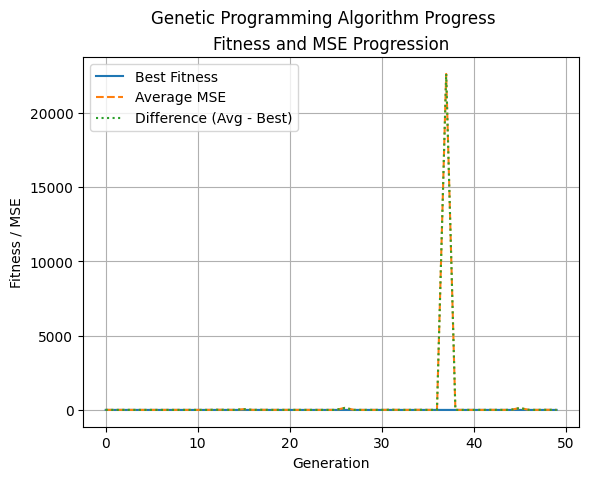

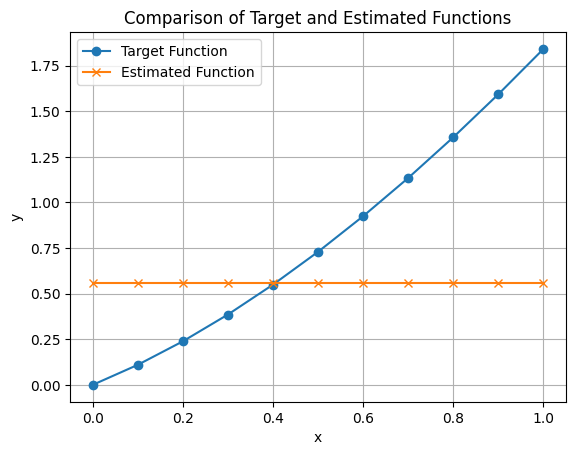

In [14]:
import math
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

# ---------- Configuration ----------
POP_SIZE = 50
MAX_DEPTH = 4
GENERATIONS = 50
NUM_CONSTANTS = 5  # how many constants to include

# Training data: x from 0 to 1.0 in steps of 0.1
TRAIN_X = [i / 10 for i in range(0, 11)]
def target_function(x):
    # Example target: sin(x) + x^2
    return math.sin(x) + x**2

TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ---------- Function and Terminal Sets ----------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {
        'name': 'pow',
        'arity': 2,
        'func': lambda a, b: (
            a ** b
            if (a > 0 or (a == 0 and b >= 0) or (a < 0 and float(b).is_integer()))
            else 1.0
        )
    },
    {'name': 'mod', 'arity': 2, 'func': lambda a, b: a % b if b != 0 else 0.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]

# Add a variable and some constants to the terminal set
TERMINALS = ['x']
for _ in range(NUM_CONSTANTS):
    TERMINALS.append(random.uniform(-2, 2))  # Add constants as floats directly

# ---------- Tree Representation ----------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value  # function dict if is_function, else string (var or const)
        self.children = children if children is not None else []

    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ---------- Tree Generation ----------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        # Must choose a terminal
        return Node(is_function=False, value=random.choice(terminals))
    else:
        # Decide whether to choose a function or terminal
        if random.random() < 0.5:  # 50% chance for function
            f = random.choice(function_set)
            if f['arity'] == 1:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ---------- Tree Evaluation ----------
def evaluate_tree(node, x_val):
    if node.is_function:
        f = node.value
        if f['arity'] == 1:
            val = evaluate_tree(node.children[0], x_val)
            return f['func'](val)
        else:
            val_left = evaluate_tree(node.children[0], x_val)
            val_right = evaluate_tree(node.children[1], x_val)
            return f['func'](val_left, val_right)
    else:
        # Terminal
        if node.value == 'x':
            return x_val
        else:
            # constant
            return float(node.value)

# ---------- Fitness ----------
def fitness(individual, train_x, train_y):
    error = 0.0
    for x_val, y_val in zip(train_x, train_y):
        pred = evaluate_tree(individual, x_val)
        error += (y_val - pred) ** 2
    return error / len(train_x)

# ---------- Simplify Tree ----------
def simplify_tree(node):
    if not node.is_function:
        return node

    simplified_children = [simplify_tree(child) for child in node.children]

    if node.value['name'] == 'add':
        if any(not c.is_function and c.value == 0 for c in simplified_children):
            return [c for c in simplified_children if not c.is_function and c.value != 0][0]
        if all(not c.is_function and isinstance(c.value, (int, float)) for c in simplified_children):
            return Node(is_function=False, value=simplified_children[0].value + simplified_children[1].value)

    if node.value['name'] == 'mul':
        if any(not c.is_function and c.value == 1 for c in simplified_children):
            return [c for c in simplified_children if not c.is_function and c.value != 1][0]
        if all(not c.is_function and isinstance(c.value, (int, float)) for c in simplified_children):
            return Node(is_function=False, value=simplified_children[0].value * simplified_children[1].value)

    return Node(is_function=True, value=node.value, children=simplified_children)

# ---------- Main Evolutionary Loop ----------
population = [generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS) for _ in range(POP_SIZE)]
best_fitness_over_generations = []
average_mse_over_generations = []
difference_best_vs_average = []

def pretty_print(node):
    if node.is_function:
        if node.value['arity'] == 1:
            return f"{node.value['name']}({pretty_print(node.children[0])})"
        return f"({pretty_print(node.children[0])} {node.value['name']} {pretty_print(node.children[1])})"
    return str(node.value)

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    best_fitness = min(fitnesses)
    best_idx = fitnesses.index(best_fitness)
    best_fitness_over_generations.append(best_fitness)
    average_mse = sum(fitnesses) / len(fitnesses)
    average_mse_over_generations.append(average_mse)
    difference_best_vs_average.append(average_mse - best_fitness)

    best_individual = population[best_idx]
    simplified_best = simplify_tree(best_individual)

    print(f"Gen {gen}, Best Fitness: {best_fitness}, Best Individual: {pretty_print(best_individual)}")
    print(f"Gen {gen}, Simplified Best Individual: {pretty_print(simplified_best)}")

    new_population = []
    while len(new_population) < POP_SIZE:
        new_population.append(generate_random_tree(MAX_DEPTH, FUNCTION_SET, TERMINALS))
    population = new_population

# Final best individual
final_best_individual = population[best_idx]
simplified_final_best = simplify_tree(final_best_individual)

print("Final Best Individual:", pretty_print(final_best_individual))
print("Final Simplified Best Individual:", pretty_print(simplified_final_best))

# Calculate accuracy
predicted_y = [evaluate_tree(final_best_individual, x) for x in TRAIN_X]
final_mse = fitness(final_best_individual, TRAIN_X, TRAIN_Y)
variance_true = np.var(TRAIN_Y)
accuracy = (1 - final_mse / variance_true) * 100
print(f"Accuracy Percentage: {accuracy:.2f}%")

# Plot best fitness over generations
plt.figure()
plt.plot(best_fitness_over_generations, label="Best Fitness")
plt.plot(average_mse_over_generations, label="Average MSE", linestyle="--")
plt.plot(difference_best_vs_average, label="Difference (Avg - Best)", linestyle=":")
plt.xlabel("Generation")
plt.ylabel("Fitness / MSE")
plt.title("Fitness and MSE Progression")
plt.suptitle("Genetic Programming Algorithm Progress")
plt.legend()
plt.grid(True)
plt.show()

# Plot target function vs estimated function
plt.figure()
plt.plot(TRAIN_X, TRAIN_Y, label="Target Function", marker="o")
plt.plot(TRAIN_X, predicted_y, label="Estimated Function", marker="x")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of Target and Estimated Functions")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
import math
import random
import copy
import statistics
#Mohem

# ----------------- Configuration -----------------
POP_SIZE = 50
MAX_DEPTH = 4
GENERATIONS = 50
NUM_CONSTANTS = 5  # Number of constants to include in the terminal set
MUTATION_RATE = 0.1

# Training data: for example x from -1.0 to 1.0 in steps of 0.1
TRAIN_X = [i/10 for i in range(-10, 11)]

def target_function(x):
    # Example target: sin(x) + x^2
    return math.sin(x) + x**2

TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ----------------- Function and Terminal Sets -----------------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {
        'name': 'pow',
        'arity': 2,
        'func': lambda a, b: (
            a ** b 
            if (a > 0 or (a == 0 and b >= 0) or (a < 0 and float(b).is_integer()))
            else 1.0
        )
    },
    {'name': 'mod', 'arity': 2, 'func': lambda a, b: a % b if b != 0 else 0.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]

TERMINALS = ['x']
for _ in range(NUM_CONSTANTS):
    TERMINALS.append(str(random.uniform(-2, 2)))  # random constants

# ----------------- Node Class -----------------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value  # function dict if is_function, else string (var or const)
        self.children = children if children is not None else []
       
    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ----------------- Tree Generation -----------------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        # Must choose a terminal
        return Node(is_function=False, value=random.choice(terminals))
    else:
        # 50% chance to choose function if possible
        if random.random() < 0.5:
            f = random.choice(function_set)
            if f['arity'] == 1:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ----------------- Tree Evaluation -----------------
def evaluate_tree(node, x_val):
    if node.is_function:
        f = node.value
        if f['arity'] == 1:
            val = evaluate_tree(node.children[0], x_val)
            return f['func'](val)
        else:
            val_left = evaluate_tree(node.children[0], x_val)
            val_right = evaluate_tree(node.children[1], x_val)
            return f['func'](val_left, val_right)
    else:
        # Terminal
        if node.value == 'x':
            return x_val
        else:
            # constant
            return float(node.value)

# ----------------- Fitness (MSE) -----------------
def fitness(individual, train_x, train_y):
    error = 0.0
    for x_val, y_val in zip(train_x, train_y):
        pred = evaluate_tree(individual, x_val)
        error += (y_val - pred)**2
    return error / len(train_x)

# ----------------- Population Initialization -----------------
def initialize_population(pop_size, max_depth, function_set, terminals):
    return [generate_random_tree(max_depth, function_set, terminals) for _ in range(pop_size)]

# ----------------- Genetic Operators -----------------
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1])
    return selected[0][0]  # best

def copy_tree(node):
    if node.is_function:
        new_children = [copy_tree(c) for c in node.children]
        return Node(is_function=True, value=node.value, children=new_children)
    else:
        return Node(is_function=False, value=node.value)

def get_all_nodes(node):
    nodes = [node]
    for c in node.children:
        nodes.extend(get_all_nodes(c))
    return nodes

def get_random_subtree(node):
    all_nodes = get_all_nodes(node)
    return random.choice(all_nodes)

def replace_subtree(original, target, replacement):
    if original is target:
        # If target is the root, handle outside
        return False
    for i, c in enumerate(original.children):
        if c is target:
            original.children[i] = replacement
            return True
        else:
            if replace_subtree(c, target, replacement):
                return True
    return False

def crossover(parent1, parent2):
    p1 = copy_tree(parent1)
    p2 = copy_tree(parent2)
    
    subtree1 = get_random_subtree(p1)
    subtree2 = get_random_subtree(p2)
    
    if p1 is subtree1:
        # Entire p1 replaced by subtree2
        return copy_tree(subtree2)
    else:
        # Replace subtree1 in p1 with subtree2
        replace_subtree(p1, subtree1, copy_tree(subtree2))
        return p1

def mutation(individual, function_set, terminals, max_depth):
    mutant = copy_tree(individual)
    subtree_to_replace = get_random_subtree(mutant)
    new_subtree = generate_random_tree(max_depth, function_set, terminals)
    if mutant is subtree_to_replace:
        return new_subtree
    replace_subtree(mutant, subtree_to_replace, new_subtree)
    return mutant

# ----------------- Pretty Print Functions -----------------
def pretty_print(node):
    """Convert a tree node into a mathematical expression string."""
    if node.is_function:
        fname = node.value['name']
        if fname == 'add':
            return f"({pretty_print(node.children[0])} + {pretty_print(node.children[1])})"
        elif fname == 'sub':
            return f"({pretty_print(node.children[0])} - {pretty_print(node.children[1])})"
        elif fname == 'mul':
            return f"({pretty_print(node.children[0])} * {pretty_print(node.children[1])})"
        elif fname == 'div':
            return f"({pretty_print(node.children[0])} / {pretty_print(node.children[1])})"
        elif fname == 'pow':
            return f"({pretty_print(node.children[0])}^{pretty_print(node.children[1])})"
        elif fname == 'mod':
            return f"({pretty_print(node.children[0])} % {pretty_print(node.children[1])})"
        elif fname == 'sin':
            return f"sin({pretty_print(node.children[0])})"
        elif fname == 'cos':
            return f"cos({pretty_print(node.children[0])})"
        elif fname == 'sqrt':
            return f"sqrt({pretty_print(node.children[0])})"
        else:
            return f"{fname}({', '.join(pretty_print(c) for c in node.children)})"
    else:
        return str(node.value)

def print_tree(node, prefix="", is_last=True):
    """Print the tree structure using box-drawing characters."""
    branch = "└── " if is_last else "├── "
    connector = "    " if is_last else "│   "
    
    line = prefix + branch
    if node.is_function:
        line += node.value['name']
    else:
        line += str(node.value)
    print(line)
    
    prefix += connector
    for i, c in enumerate(node.children):
        print_tree(c, prefix=prefix, is_last=(i == len(node.children)-1))

# ----------------- Main Evolutionary Loop -----------------
population = initialize_population(POP_SIZE, MAX_DEPTH, FUNCTION_SET, TERMINALS)

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    
    best_idx = min(range(len(population)), key=lambda i: fitnesses[i])
    print(f"Gen {gen}, Best Fitness: {fitnesses[best_idx]}, Best Individual: {population[best_idx]}")

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses, k=3)
        p2 = tournament_selection(population, fitnesses, k=3)
        child = crossover(p1, p2)
        if random.random() < MUTATION_RATE:
            child = mutation(child, FUNCTION_SET, TERMINALS, MAX_DEPTH)
        new_population.append(child)
    
    population = new_population

# After evolution, find and print the best solution
fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
best_idx = min(range(len(population)), key=lambda i: fitnesses[i])
best_individual = population[best_idx]
best_fitness = fitnesses[best_idx]

print("\nFinal Best Individual (Mathematical Form):")
print(pretty_print(best_individual))

print("\nFinal Best Individual (Tree Structure):")
print_tree(best_individual)

# Calculate Accuracy Percentage
variance_of_true = statistics.pvariance(TRAIN_Y)
accuracy_percentage = (1 - (best_fitness / variance_of_true)) * 100

print(f"\nFinal Best Fitness (MSE): {best_fitness}")
print(f"Variance of True Outputs: {variance_of_true}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")


Gen 0, Best Fitness: 0.2460755278486781, Best Individual: x
Gen 1, Best Fitness: 0.11744918220874334, Best Individual: (sin(0.26102197662197657) sub ((-0.43883810130312817 sub x) add (-0.43883810130312817 mod 0.8453540443515788)))
Gen 2, Best Fitness: 0.11609845831844108, Best Individual: (0.2675060844762962 sub ((-0.43883810130312817 sub x) add (-0.43883810130312817 mod 0.8453540443515788)))
Gen 3, Best Fitness: 0.11744918220874334, Best Individual: (sin(0.26102197662197657) sub ((-0.43883810130312817 sub x) add (-0.43883810130312817 mod 0.8453540443515788)))
Gen 4, Best Fitness: 0.11609845831844108, Best Individual: (0.2675060844762962 sub ((-0.43883810130312817 sub x) add (-0.43883810130312817 mod 0.8453540443515788)))
Gen 5, Best Fitness: 0.11609845831844108, Best Individual: (0.2675060844762962 sub ((-0.43883810130312817 sub x) add (-0.43883810130312817 mod 0.8453540443515788)))
Gen 6, Best Fitness: 0.11609845831844108, Best Individual: (0.2675060844762962 sub ((-0.438838101303128

Gen 0, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 1, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 2, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 3, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 4, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 5, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 6, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 7, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 8, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 9, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 10, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 11, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 12, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 13, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 14, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 15, Best Fitness: 0.21779285925020192, Best Individual: x
Gen 16, Best Fitne

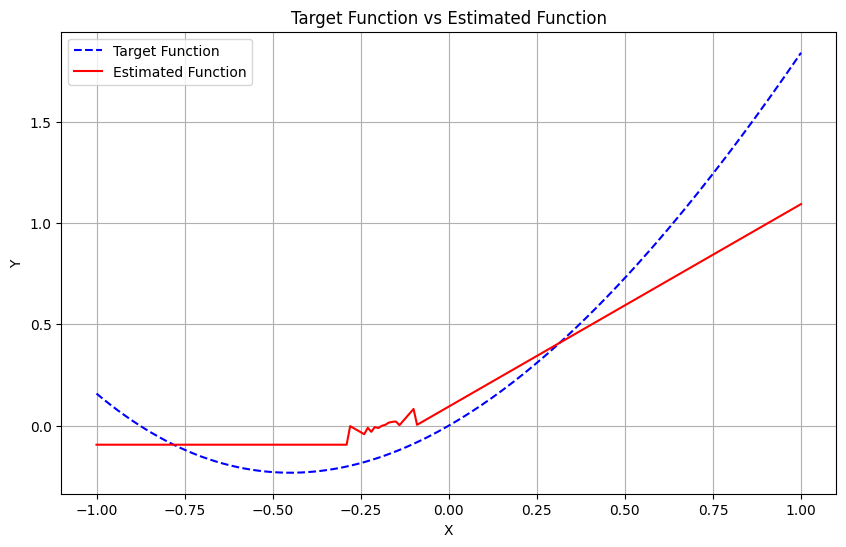

In [16]:
import math
import random
import copy
import statistics
import matplotlib.pyplot as plt

# ----------------- Configuration -----------------
POP_SIZE = 100  # Increased population size
MAX_DEPTH = 5  # Increased max depth for more complex trees
GENERATIONS = 100  # Increased generations for better convergence
NUM_CONSTANTS = 5  # Number of constants to include in the terminal set
MUTATION_RATE = 0.2  # Adjusted mutation rate

# Training data: for example x from -1.0 to 1.0 in steps of 0.1
TRAIN_X = [i / 100 for i in range(-100, 101)]  # Increased resolution

def target_function(x):
    # Example target: sin(x) + x^2
    return math.sin(x) + x**2

TRAIN_Y = [target_function(x) for x in TRAIN_X]

# ----------------- Function and Terminal Sets -----------------
FUNCTION_SET = [
    {'name': 'add', 'arity': 2, 'func': lambda a, b: a + b},
    {'name': 'sub', 'arity': 2, 'func': lambda a, b: a - b},
    {'name': 'mul', 'arity': 2, 'func': lambda a, b: a * b},
    {'name': 'div', 'arity': 2, 'func': lambda a, b: a / b if b != 0 else 1.0},
    {
        'name': 'pow',
        'arity': 2,
        'func': lambda a, b: (
            a ** b
            if (a > 0 or (a == 0 and b >= 0) or (a < 0 and float(b).is_integer()))
            else 1.0
        )
    },
    {'name': 'mod', 'arity': 2, 'func': lambda a, b: a % b if b != 0 else 0.0},
    {'name': 'sin', 'arity': 1, 'func': lambda a: math.sin(a)},
    {'name': 'cos', 'arity': 1, 'func': lambda a: math.cos(a)},
    {'name': 'sqrt', 'arity': 1, 'func': lambda a: math.sqrt(abs(a))}
]

TERMINALS = ['x', 1.0, 0.5, 2.0]  # Specific constants likely to be in the target function
for _ in range(NUM_CONSTANTS):
    TERMINALS.append(random.uniform(-2, 2))  # Random constants

# ----------------- Node Class -----------------
class Node:
    def __init__(self, is_function, value, children=None):
        self.is_function = is_function
        self.value = value  # function dict if is_function, else string (var or const)
        self.children = children if children is not None else []

    def __str__(self):
        if self.is_function:
            if self.value['arity'] == 1:
                return f"{self.value['name']}({self.children[0]})"
            else:
                return f"({self.children[0]} {self.value['name']} {self.children[1]})"
        else:
            return str(self.value)

# ----------------- Tree Generation -----------------
def generate_random_tree(max_depth, function_set, terminals):
    if max_depth == 0:
        # Must choose a terminal
        return Node(is_function=False, value=random.choice(terminals))
    else:
        # 50% chance to choose function if possible
        if random.random() < 0.5:
            f = random.choice(function_set)
            if f['arity'] == 1:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
            else:
                return Node(is_function=True, value=f, children=[
                    generate_random_tree(max_depth - 1, function_set, terminals),
                    generate_random_tree(max_depth - 1, function_set, terminals)
                ])
        else:
            return Node(is_function=False, value=random.choice(terminals))

# ----------------- Tree Evaluation -----------------
def evaluate_tree(node, x_val):
    if node.is_function:
        f = node.value
        if f['arity'] == 1:
            val = evaluate_tree(node.children[0], x_val)
            return f['func'](val)
        else:
            val_left = evaluate_tree(node.children[0], x_val)
            val_right = evaluate_tree(node.children[1], x_val)
            return f['func'](val_left, val_right)
    else:
        # Terminal
        if node.value == 'x':
            return x_val
        else:
            # constant
            return float(node.value)

# ----------------- Fitness (MSE with Penalty) -----------------
def fitness(individual, train_x, train_y):
    error = 0.0
    for x_val, y_val in zip(train_x, train_y):
        pred = evaluate_tree(individual, x_val)
        error += (y_val - pred)**2
    complexity_penalty = len(get_all_nodes(individual)) * 0.01  # Penalize larger trees
    return (error / len(train_x)) + complexity_penalty

# ----------------- Population Initialization -----------------
def initialize_population(pop_size, max_depth, function_set, terminals):
    return [generate_random_tree(max_depth, function_set, terminals) for _ in range(pop_size)]

# ----------------- Genetic Operators -----------------
def tournament_selection(population, fitnesses, k=5):
    selected = random.sample(list(zip(population, fitnesses)), k)
    selected.sort(key=lambda x: x[1])
    return selected[0][0]  # best

def copy_tree(node):
    if node.is_function:
        new_children = [copy_tree(c) for c in node.children]
        return Node(is_function=True, value=node.value, children=new_children)
    else:
        return Node(is_function=False, value=node.value)

def get_all_nodes(node):
    nodes = [node]
    for c in node.children:
        nodes.extend(get_all_nodes(c))
    return nodes

def get_random_subtree(node):
    all_nodes = get_all_nodes(node)
    return random.choice(all_nodes)

def replace_subtree(original, target, replacement):
    if original is target:
        # If target is the root, handle outside
        return False
    for i, c in enumerate(original.children):
        if c is target:
            original.children[i] = replacement
            return True
        else:
            if replace_subtree(c, target, replacement):
                return True
    return False

def crossover(parent1, parent2):
    p1 = copy_tree(parent1)
    p2 = copy_tree(parent2)
    
    subtree1 = get_random_subtree(p1)
    subtree2 = get_random_subtree(p2)
    
    if p1 is subtree1:
        # Entire p1 replaced by subtree2
        return copy_tree(subtree2)
    else:
        # Replace subtree1 in p1 with subtree2
        replace_subtree(p1, subtree1, copy_tree(subtree2))
        return p1

def mutation(individual, function_set, terminals, max_depth):
    mutant = copy_tree(individual)
    subtree_to_replace = get_random_subtree(mutant)
    new_subtree = generate_random_tree(max_depth, function_set, terminals)
    if mutant is subtree_to_replace:
        return new_subtree
    replace_subtree(mutant, subtree_to_replace, new_subtree)
    return mutant

# ----------------- Pretty Print Functions -----------------
def pretty_print(node):
    """Convert a tree node into a mathematical expression string."""
    if node.is_function:
        fname = node.value['name']
        if fname == 'add':
            return f"({pretty_print(node.children[0])} + {pretty_print(node.children[1])})"
        elif fname == 'sub':
            return f"({pretty_print(node.children[0])} - {pretty_print(node.children[1])})"
        elif fname == 'mul':
            return f"({pretty_print(node.children[0])} * {pretty_print(node.children[1])})"
        elif fname == 'div':
            return f"({pretty_print(node.children[0])} / {pretty_print(node.children[1])})"
        elif fname == 'pow':
            return f"({pretty_print(node.children[0])}^{pretty_print(node.children[1])})"
        elif fname == 'mod':
            return f"({pretty_print(node.children[0])} % {pretty_print(node.children[1])})"
        elif fname == 'sin':
            return f"sin({pretty_print(node.children[0])})"
        elif fname == 'cos':
            return f"cos({pretty_print(node.children[0])})"
        elif fname == 'sqrt':
            return f"sqrt({pretty_print(node.children[0])})"
        else:
            return f"{fname}({', '.join(pretty_print(c) for c in node.children)})"
    else:
        return str(node.value)

def print_tree(node, prefix="", is_last=True):
    """Print the tree structure using box-drawing characters."""
    branch = "└── " if is_last else "├── "
    connector = "    " if is_last else "│   "
    
    line = prefix + branch
    if node.is_function:
        line += node.value['name']
    else:
        line += str(node.value)
    print(line)
    
    prefix += connector
    for i, c in enumerate(node.children):
        print_tree(c, prefix=prefix, is_last=(i == len(node.children)-1))

# ----------------- Main Evolutionary Loop -----------------
population = initialize_population(POP_SIZE, MAX_DEPTH, FUNCTION_SET, TERMINALS)

for gen in range(GENERATIONS):
    fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
    
    best_idx = min(range(len(population)), key=lambda i: fitnesses[i])
    print(f"Gen {gen}, Best Fitness: {fitnesses[best_idx]}, Best Individual: {population[best_idx]}")

    new_population = []
    while len(new_population) < POP_SIZE:
        p1 = tournament_selection(population, fitnesses, k=5)
        p2 = tournament_selection(population, fitnesses, k=5)
        child = crossover(p1, p2)
        if random.random() < MUTATION_RATE:
            child = mutation(child, FUNCTION_SET, TERMINALS, MAX_DEPTH)
        new_population.append(child)
    
    population = new_population

# After evolution, find and print the best solution
fitnesses = [fitness(ind, TRAIN_X, TRAIN_Y) for ind in population]
best_idx = min(range(len(population)), key=lambda i: fitnesses[i])
best_individual = population[best_idx]
best_fitness = fitnesses[best_idx]

print("\nFinal Best Individual (Mathematical Form):")
print(pretty_print(best_individual))

print("\nFinal Best Individual (Tree Structure):")
print_tree(best_individual)

# Calculate Accuracy Percentage
variance_of_true = statistics.pvariance(TRAIN_Y)
accuracy_percentage = (1 - (best_fitness / variance_of_true)) * 100

print(f"\nFinal Best Fitness (MSE): {best_fitness}")
print(f"Variance of True Outputs: {variance_of_true}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")

# Plot Target Function vs Estimated Function
plt.figure(figsize=(10, 6))
plt.plot(TRAIN_X, TRAIN_Y, label="Target Function", linestyle="--", color="blue")
estimated_y = [evaluate_tree(best_individual, x) for x in TRAIN_X]
plt.plot(TRAIN_X, estimated_y, label="Estimated Function", color="red")
plt.legend()
plt.title("Target Function vs Estimated Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()
